In [4]:
# DATA Segment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scaler import StandardScalerLSTM

SEQ_LEN = 8
BATCH_SIZE = 16 
FEATURE_SIZE = 12

# def scale_data(data):
#     num_features = data.shape[1]
#     scale_params = np.zeros((num_features,2))
#     mins = np.min(data, axis=0);maxes=np.max(data, axis=0)
#     data = (data - mins) / (maxes - mins)
#     return data, scale_params

data_df = pd.read_csv("data/final_dataset.csv")

data_df = data_df.drop(['Date'], axis=1)
data_df = data_df.iloc[1900:,:]
data = np.nan_to_num(np.array(data_df, dtype=np.float32))

# ====================== Data ========================

# Scaler
minmax_scaler = StandardScalerLSTM(batch_size=BATCH_SIZE, sequence_length=SEQ_LEN, feature_size=FEATURE_SIZE)
minmax_scaler.fit(data)

def create_sequence(data,seq_len):
    xs = []
    ys = []
    for i in range(len(data)-seq_len-1):
        x = data[i:(i+seq_len),:]
        # print(x.shape)
        y = data[i+seq_len,0]
        xs.append(x)
        ys.append(y)
    return np.array(xs),np.array(ys)

inputs , targets = create_sequence(data,SEQ_LEN)
inputs=torch.from_numpy(inputs);targets=torch.from_numpy(targets)

# split the input data into train and test data
train_size = int(0.8 * len(inputs))
test_size = len(inputs) - train_size
train_inputs, test_inputs = inputs[:train_size], inputs[train_size:]
train_targets, test_targets = targets[:train_size], targets[train_size:]
print(train_inputs.shape, test_inputs.shape)
# ====================== Data ========================



mean (12,)
scale (12,)
torch.Size([3148, 8, 12]) torch.Size([788, 8, 12])


In [5]:

# ====================== Model ======================== 
class PricePredictor(nn.Module):
    def __init__(self,scaler, input_size=12, hidden_layer_size=150, time_segment=5, output_size=1):
        super().__init__()
        self.scaler = scaler
        self.hidden_layer_size = hidden_layer_size
        self.time_segment_length = time_segment
        self.lstm = nn.LSTM(input_size, hidden_layer_size,batch_first=True) # N x L x input_size(12)
        self.linear = nn.Linear(hidden_layer_size, output_size) # N x L x output_size(1)
        self.ReLU = nn.ReLU()
        self.cell_double = None

    def forward(self, input_seq):
        '''
            input : N x L x input_size
            ouput : N x output_size
        '''
        input_seq = self.scaler(input_seq)
        output,_ = self.lstm(input_seq) # N x L x hidden_layer_size
        output = self.ReLU(output)
        predictions = self.linear(output[:,-1,:].squeeze()) # N x output_size
        predictions = self.scaler.inverse_transform(predictions)
        return predictions

# ====================== Model ========================

/home/rahulkumar/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/rahulkumar/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/rahulkumar/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the 

Test loss: 105684184.00000000
Test loss: 30976568.00000000
Test loss: 26477326.00000000
Test loss: 24660536.00000000
Test loss: 23511850.00000000
Test loss: 22708102.00000000


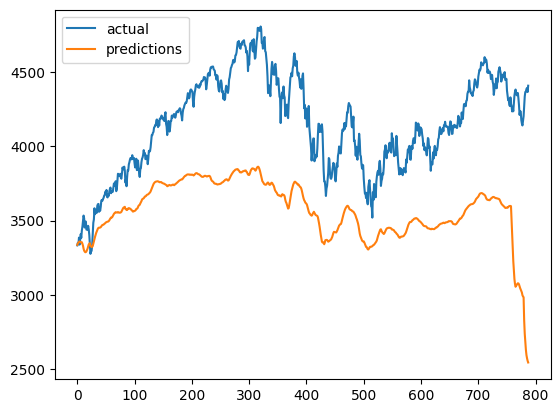

In [6]:
train_dataset = TensorDataset(train_inputs, train_targets)
test_dataset = TensorDataset(test_inputs, test_targets)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


model = PricePredictor(minmax_scaler)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)

epochs = 30

for i in range(epochs):
    for seq, targets in train_loader:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, targets)
        single_loss.backward()
        optimizer.step()

    if(i%5==0):
        # print the test loss
        with torch.no_grad():
            test_loss_ = 0
            for seq_, targets_ in test_loader:
                y_pred_test = model(seq_)
                test_loss_ += loss_function(y_pred_test, targets_)
                # print(y_pred_test.shape)
            print(f'Test loss: {test_loss_.item():10.8f}')
    
actual_prices = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for seq, targets in test_loader:
        y_pred = model(seq)
        actual_prices.extend(targets.flatten())
        predictions.extend(y_pred.flatten())


actual_prices = np.array(actual_prices)
predictions = np.array(predictions)
x = np.arange(len(actual_prices))

plt.plot(x,actual_prices, label="actual")
plt.plot(x,predictions, label="predictions")
plt.legend()
plt.show()
